In [1]:
import copy
import functools
import os
import pickle

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage, stats

In [3]:
import lib

In [4]:
gal_weight_file = "/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v6_UNBLINDED/inverse_variance_weight_v6.pickle"

In [5]:
with open(gal_weight_file, 'rb') as handle:
    wgt_dict = pickle.load(handle)

In [6]:
xedges = wgt_dict['xedges']  # S/N
yedges = wgt_dict['yedges']  # T/Tpsf
smooth_response = ndimage.gaussian_filter(wgt_dict['response'], sigma=2.0)

In [7]:
size_ratio_bins = yedges
snr_bins = xedges

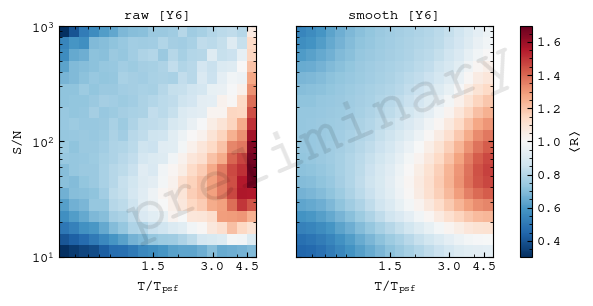

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

norm = mpl.colors.CenteredNorm(1.0)
cmap = "RdBu_r"

axs[0].pcolormesh(
    size_ratio_bins,
    snr_bins,
    wgt_dict['response'],
    norm=norm,
    cmap=cmap,
)
axs[1].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response,
    norm=norm,
    cmap=cmap,
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins="auto"))

axs[0].set_xlabel("$T/T_{psf}$")
axs[1].set_xlabel("$T/T_{psf}$")
axs[0].set_ylabel("$S/N$")

axs[0].set_title("raw [Y6]")
axs[1].set_title("smooth [Y6]")

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel().tolist(),
    label="$〈R〉$",
)

lib.plotting.watermark(fig)

plt.show()

In [9]:
def _get_response_grid(shear_step, snr_bins, size_ratio_bins, weight=False):
    snr_bins = np.copy(snr_bins)
    # snr_bins[0] = -np.inf
    snr_bins[-1] = np.inf

    size_ratio_bins = np.copy(size_ratio_bins)
    # size_ratio_bins[0] = -np.inf
    size_ratio_bins[-1] = np.inf

    with h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear_sim:
        size_ratio_1p = shear_sim["mdet"]["1p"]["gauss_T_ratio"][:]
        snr_1p = shear_sim["mdet"]["1p"]["gauss_s2n"][:]
        g1_1p = shear_sim["mdet"]["1p"]["gauss_g_1"][:]
        if weight:
            w_1p = lib.weight.get_shear_weights(shear_sim["mdet"]["1p"])
    
        size_ratio_1m = shear_sim["mdet"]["1m"]["gauss_T_ratio"][:]
        snr_1m = shear_sim["mdet"]["1m"]["gauss_s2n"][:]
        g1_1m = shear_sim["mdet"]["1m"]["gauss_g_1"][:]
        if weight:
            w_1m = lib.weight.get_shear_weights(shear_sim["mdet"]["1m"])
    
        size_ratio_2p = shear_sim["mdet"]["2p"]["gauss_T_ratio"][:]
        snr_2p = shear_sim["mdet"]["2p"]["gauss_s2n"][:]
        g2_2p = shear_sim["mdet"]["2p"]["gauss_g_2"][:]
        if weight:
            w_2p = lib.weight.get_shear_weights(shear_sim["mdet"]["2p"])
    
        size_ratio_2m = shear_sim["mdet"]["2m"]["gauss_T_ratio"][:]
        snr_2m = shear_sim["mdet"]["2m"]["gauss_s2n"][:]
        g2_2m = shear_sim["mdet"]["2m"]["gauss_g_2"][:]
        if weight:
            w_2m = lib.weight.get_shear_weights(shear_sim["mdet"]["2m"])

    if weight:
        _g1_1p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1p,
            size_ratio_1p,
            g1_1p * w_1p,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        w_1p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1p,
            size_ratio_1p,
            w_1p,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        g1_1p_grid = _g1_1p_grid / w_1p_grid
    else:
        g1_1p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1p,
            size_ratio_1p,
            g1_1p,
            statistic="mean",
            bins=[snr_bins, size_ratio_bins],
        )

    if weight:
        _g1_1m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1m,
            size_ratio_1m,
            g1_1m * w_1m,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        w_1m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1m,
            size_ratio_1m,
            w_1m,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        g1_1m_grid = _g1_1m_grid / w_1m_grid
    else:
        g1_1m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_1m,
            size_ratio_1m,
            g1_1m,
            statistic="mean",
            bins=[snr_bins, size_ratio_bins],
        )

    if weight:
        _g2_2p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2p,
            size_ratio_2p,
            g2_2p * w_2p,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        w_2p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2p,
            size_ratio_2p,
            w_2p,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        g2_2p_grid = _g2_2p_grid / w_2p_grid
    else:
        g2_2p_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2p,
            size_ratio_2p,
            g2_2p,
            statistic="mean",
            bins=[snr_bins, size_ratio_bins],
        )

    if weight:
        _g2_2m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2m,
            size_ratio_2m,
            g2_2m * w_2m,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        w_2m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2m,
            size_ratio_2m,
            w_2m,
            statistic="sum",
            bins=[snr_bins, size_ratio_bins],
        )
        g2_2m_grid = _g2_2m_grid / w_2m_grid
    else:
        g2_2m_grid, _, _, _ = stats.binned_statistic_2d(
            snr_2m,
            size_ratio_2m,
            g2_2m,
            statistic="mean",
            bins=[snr_bins, size_ratio_bins],
        )
    
    R_11_grid = (g1_1p_grid - g1_1m_grid) / (2 * 0.01)
    R_22_grid = (g2_2p_grid - g2_2m_grid) / (2 * 0.01)
    
    response_grid = 0.5 * (R_11_grid + R_22_grid)

    return response_grid, snr_bins, size_ratio_bins

In [10]:
def get_response_grid(snr_bins, size_ratio_bins, weight=False):
    shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
    shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

    response_sim_p, _, _ = _get_response_grid(shear_step_plus, snr_bins, size_ratio_bins, weight=weight)
    response_sim_m, _, _ = _get_response_grid(shear_step_minus, snr_bins, size_ratio_bins, weight=weight)

    response_sim = 0.5 * (response_sim_p + response_sim_m)

    return response_sim, snr_bins, size_ratio_bins

In [11]:
response_sim, _, _ = get_response_grid(snr_bins, size_ratio_bins)

In [12]:
response_sim_weighted, _, _ = get_response_grid(snr_bins, size_ratio_bins, weight=True)

In [13]:
smooth_response_sim = ndimage.gaussian_filter(response_sim, sigma=2.0)
smooth_response_sim_weighted = ndimage.gaussian_filter(response_sim_weighted, sigma=2.0)

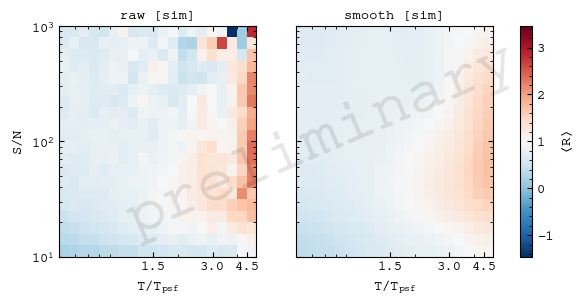

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

norm = mpl.colors.CenteredNorm(1.0)
cmap = "RdBu_r"

axs[0].pcolormesh(
    size_ratio_bins,
    snr_bins,
    response_sim,
    norm=norm,
    cmap=cmap,
)
axs[1].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim,
    norm=norm,
    cmap=cmap,
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins="auto"))

axs[0].set_xlabel("$T/T_{psf}$")
axs[1].set_xlabel("$T/T_{psf}$")
axs[0].set_ylabel("$S/N$")

axs[0].set_title("raw [sim]")
axs[1].set_title("smooth [sim]")

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel().tolist(),
    label="$〈R〉$",
)

lib.plotting.watermark(fig)

plt.show()

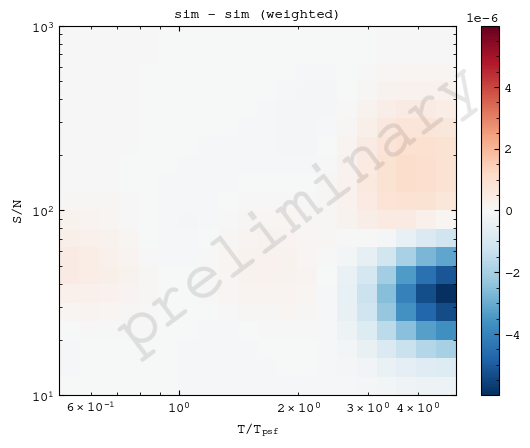

In [15]:
fig, axs = plt.subplots(1, 1)

norm = mpl.colors.CenteredNorm(0.0)
cmap = "RdBu_r"

m = axs.pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim - smooth_response_sim_weighted,
    norm=norm,
    cmap=cmap,
)

axs.set_xscale("log")
axs.set_yscale("log")

axs.set_xlabel("$T/T_{psf}$")
axs.set_ylabel("$S/N$")
axs.set_title("sim - sim (weighted)")

plt.colorbar(m)

lib.plotting.watermark(fig)

plt.show()

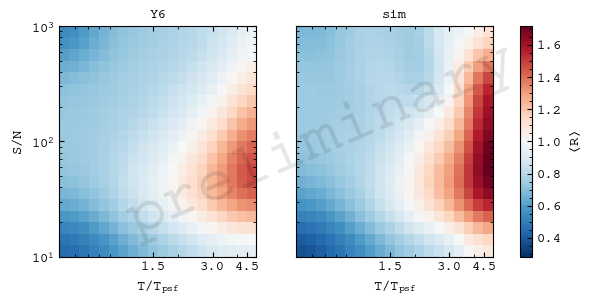

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

norm = mpl.colors.CenteredNorm(1.0)
cmap = "RdBu_r"

axs[1].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim,
    norm=norm,
    cmap=cmap,
)
axs[0].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response,
    norm=norm,
    cmap=cmap,
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins="auto"))

axs[0].set_xlabel("$T/T_{psf}$")
axs[1].set_xlabel("$T/T_{psf}$")
axs[0].set_ylabel("$S/N$")

axs[0].set_title("Y6")
axs[1].set_title("sim")

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel().tolist(),
    label="$〈R〉$",
)

lib.plotting.watermark(fig)

plt.show()

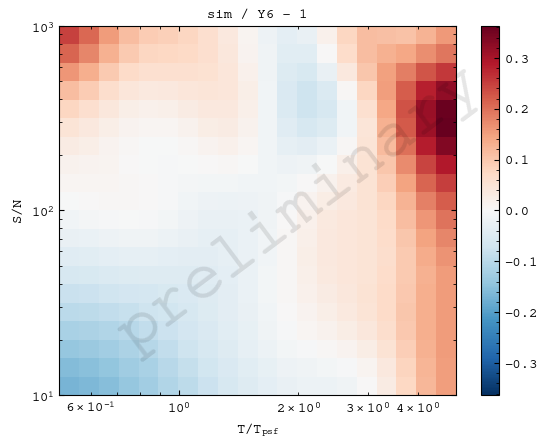

In [17]:
fig, axs = plt.subplots(1, 1)

norm = mpl.colors.CenteredNorm(0.0)
cmap = "RdBu_r"

m = axs.pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim / smooth_response - 1,
    norm=norm,
    cmap=cmap,
)

axs.set_xscale("log")
axs.set_yscale("log")

axs.set_xlabel("$T/T_{psf}$")
axs.set_ylabel("$S/N$")
axs.set_title("sim / Y6 - 1")

plt.colorbar(m)

lib.plotting.watermark(fig)

plt.show()

In [18]:
wgt_dict_sim = copy.deepcopy(wgt_dict)

In [19]:
wgt_dict_sim["response"] = response_sim

In [24]:
sim_weight_file = "inverse_variance_weight_v6_sim.pickle"

In [25]:
with open(sim_weight_file, 'wb') as handle:
    pickle.dump(wgt_dict_sim, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open(sim_weight_file, 'rb') as handle:
    sim_wgt_dict = pickle.load(handle)

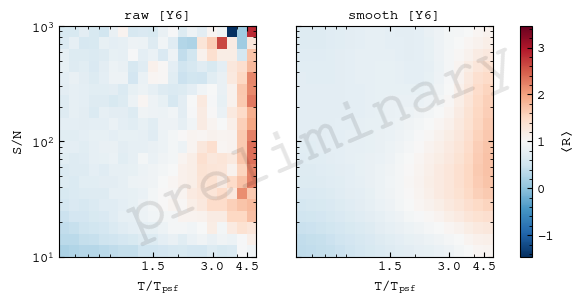

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

norm = mpl.colors.CenteredNorm(1.0)
cmap = "RdBu_r"

axs[0].pcolormesh(
    wgt_dict['yedges'],
    wgt_dict['xedges'],
    sim_wgt_dict['response'],
    norm=norm,
    cmap=cmap,
)
axs[1].pcolormesh(
    wgt_dict['yedges'],
    wgt_dict['xedges'],
    ndimage.gaussian_filter(sim_wgt_dict['response'], sigma=2.0),
    norm=norm,
    cmap=cmap,
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins="auto"))

axs[0].set_xlabel("$T/T_{psf}$")
axs[1].set_xlabel("$T/T_{psf}$")
axs[0].set_ylabel("$S/N$")

axs[0].set_title("raw [Y6]")
axs[1].set_title("smooth [Y6]")

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel().tolist(),
    label="$〈R〉$",
)

lib.plotting.watermark(fig)

plt.show()